# BPI challenge 2019

In [31]:
import pandas as pd
import pm4py as pm
import numpy as np

In [66]:
log = pm.read_xes("BPI_Challenge_2019.xes") #Input Filename
df = pm.convert_to_dataframe(log)
df.head()

parsing log, completed traces ::   0%|          | 0/251734 [00:00<?, ?it/s]

,User,org:resource,concept:name,Cumulative net worth (EUR),time:timestamp,case:Spend area text,case:Company,case:Document Type,case:Sub spend area text,case:Purchasing Document,...,case:Vendor,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:concept:name,case:Goods Receipt
0,batch_00,batch_00,SRM: Created,298.0,2018-01-02 12:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True
1,batch_00,batch_00,SRM: Complete,298.0,2018-01-02 13:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True
2,batch_00,batch_00,SRM: Awaiting Approval,298.0,2018-01-02 13:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True
3,batch_00,batch_00,SRM: Document Completed,298.0,2018-01-02 13:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True
4,batch_00,batch_00,SRM: In Transfer to Execution Syst.,298.0,2018-01-02 13:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True


## Preprocessing

In [67]:
#Removing duplicate rows
df.drop_duplicates(inplace=True)

### Filter by Date

In [68]:
df = df[(df["time:timestamp"] < '2019-01-28') & (df["time:timestamp"] > '2018-01-01')]

### Filter by Duration

First filter case with 0 duration, then maintain only case that ends with "Delete Purchase Order Item" because they are already concluded cases (so a 0 duration is acceptable)

In [69]:
## Let's verify we have cases with duration 0
case_durations = pm.get_all_case_durations(df)

min_case_duration = min(case_durations)
max_case_duration = max(case_durations)
mean_case_duration = np.mean(case_durations)

print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration, max_case_duration, mean_case_duration))

Min Case Duration: 0.0
Max Case Duration: 32827800.0
Mean Case Duration: 6007096.324135794


In [70]:
zero_dur_df = pm.filter_case_performance(df, 0, 0)

In [71]:
end_activity = pm.get_end_activities(zero_dur_df)
end_activity

{'Create Purchase Order Item': 2835,
 'Record Goods Receipt': 363,
 'Record Service Entry Sheet': 330,
 'Delete Purchase Order Item': 55,
 'Change Delivery Indicator': 1,
 'Change payment term': 1}

In [72]:
#Maintain only variants that end with "Delete Purchase Order Item"
end_activity_to_maintain = ["Delete Purchase Order Item"]
end_activity_to_delete = list(set(end_activity) - set(end_activity_to_maintain))
zero_dur_filtered_df = pm.filter_end_activities(zero_dur_df, end_activity_to_delete)

In [73]:
#Difference between datasets
df_2 = pd.concat([df, zero_dur_filtered_df]).drop_duplicates(keep=False)

### Filter Incomplete and Uncompliant cases

In [74]:
def remove_non_compliant(df, type):
    df_non_compliant = pd.DataFrame()
    
    for case, subdf in df.groupby(by=["case:concept:name"]):
        
        non_compliant = False
        gr = 0 
        ir = 0
        ci = 0
        
        events = subdf["concept:name"].to_list()
        
        gr = events.count("Record Goods Receipt")
        ir = events.count("Record Invoice Receipt")
        ci = events.count("Clear Invoice")

        if(type==1 or type==2):
            if(gr == 0 or ir == 0 or gr != ir or ir != ci):
                non_compliant = True
        elif(type==3):
            if(ir == 0 or ir != ci):
                non_compliant = True

        if non_compliant:
            #print(case)
            df_non_compliant = pd.concat([df_non_compliant, subdf])

    return pd.concat([df, df_non_compliant]).drop_duplicates(keep=False)

def count_cases(df):
    cases = 0

    for case, subdf in df.groupby(by=["case:concept:name"]):
        cases += 1

    return cases   

#### 3-way matching, invoice after goods receipt

In [75]:
type_1_df = df_2[(df_2['case:Item Category'] == "3-way match, invoice after GR")]

type_1_og_num_cases = count_cases(type_1_df)

#Removing incomplete cases
ending_activities = pm.get_end_activities(type_1_df)
ending_activities_to_maintain = ["Clear Invoice"]
ending_activities_to_delete = list(set(ending_activities) - set(ending_activities_to_maintain))

type_1_df = pd.concat([type_1_df, pm.filter_end_activities(type_1_df, ending_activities_to_delete)]).drop_duplicates(keep=False)

#Removing non-compliant cases
type_1_df = remove_non_compliant(type_1_df, 1)

type_1_new_num_cases = count_cases(type_1_df)
print(type_1_og_num_cases, type_1_new_num_cases)

14366 7516


#### 3-way matching, invoice before goods receipt

In [76]:
type_2_df = df_2[(df_2['case:Item Category'] == "3-way match, invoice before GR")]

type_2_og_num_cases = count_cases(type_2_df)

#Removing incomplete cases
ending_activities = pm.get_end_activities(type_2_df)
ending_activities_to_maintain = ["Clear Invoice"]
ending_activities_to_delete = list(set(ending_activities) - set(ending_activities_to_maintain))

type_2_df = pd.concat([type_2_df, pm.filter_end_activities(type_2_df, ending_activities_to_delete)]).drop_duplicates(keep=False)

#Removing non-compliant cases
type_2_df = remove_non_compliant(type_2_df, 2)

type_2_new_num_cases = count_cases(type_2_df)
print(type_2_og_num_cases, type_2_new_num_cases)

218539 162319


#### 2-way matching

In [77]:
type_3_df = df_2[(df_2['case:Item Category'] == "2-way match")]

type_3_og_num_cases = count_cases(type_3_df)

#Removing incomplete cases
ending_activities = pm.get_end_activities(type_3_df)
ending_activities_to_maintain = ["Clear Invoice"]
ending_activities_to_delete = list(set(ending_activities) - set(ending_activities_to_maintain))

type_3_df = pd.concat([type_3_df, pm.filter_end_activities(type_3_df, ending_activities_to_delete)]).drop_duplicates(keep=False)

#Removing non-compliant cases
type_3_df = remove_non_compliant(type_3_df, 3)

type_3_new_num_cases = count_cases(type_3_df)
print(type_3_og_num_cases, type_3_new_num_cases)

1044 166


#### Consignment

In [78]:
type_4_df = df_2[(df_2['case:Item Category'] == "Consignment")]

type_4_og_num_cases = count_cases(type_4_df)

#Removing incomplete cases
ending_activities = pm.get_end_activities(type_4_df)
ending_activities_to_maintain = ["Record Goods Receipt"]
ending_activities_to_delete = list(set(ending_activities) - set(ending_activities_to_maintain))

type_4_df = pd.concat([type_4_df, pm.filter_end_activities(type_4_df, ending_activities_to_delete)]).drop_duplicates(keep=False)

type_4_new_num_cases = count_cases(type_4_df)
print(type_4_og_num_cases, type_4_new_num_cases)

14255 13130


### Vizualize Results

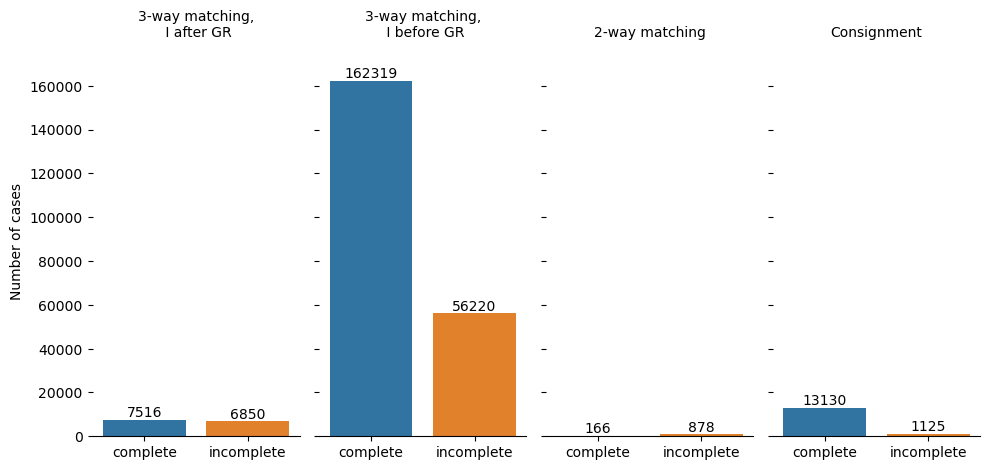

In [16]:
import seaborn as sns

visualize_df = pd.DataFrame([[type_1_new_num_cases, "3-way matching,\n I after GR", "complete"], 
                             [type_1_og_num_cases - type_1_new_num_cases, "3-way matching,\n I after GR", "incomplete"],
                             [type_2_new_num_cases, "3-way matching,\n I before GR", "complete"],
                             [type_2_og_num_cases - type_2_new_num_cases, "3-way matching,\n I before GR", "incomplete"],
                             [type_3_new_num_cases, "2-way matching", "complete"],
                             [type_3_og_num_cases - type_3_new_num_cases, "2-way matching", "incomplete"],
                             [type_4_new_num_cases, "Consignment", "complete"],
                             [type_4_og_num_cases - type_4_new_num_cases, "Consignment", "incomplete"]],
                            columns=['count', 'type', 'case'])


g = sns.catplot(
    visualize_df, kind="bar",
    x="case", y="count", col="type",
    height=5, aspect=.5,
)
g.set_axis_labels("", "Number of cases")
g.set_xticklabels(["complete", "incomplete"])
g.set_titles("{col_name}")

#Add values on bars
for ax in g.axes.ravel():
    # add annotations
    for c in ax.containers:
        ax.bar_label(c, label_type='edge')
    ax.margins(y=0.1)

g.despine(left=True)

## Process Discovery

Merge the 4 filtered dataset of the previous section into one single dataset

In [79]:
filtered_df = pd.concat([type_1_df, type_2_df, type_3_df, type_4_df])
filtered_df.head()

,User,org:resource,concept:name,Cumulative net worth (EUR),time:timestamp,case:Spend area text,case:Company,case:Document Type,case:Sub spend area text,case:Purchasing Document,...,case:Vendor,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:concept:name,case:Goods Receipt
145,batch_00,batch_00,SRM: Created,18186.0,2018-01-08 14:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
146,batch_00,batch_00,SRM: Complete,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
147,batch_00,batch_00,SRM: Awaiting Approval,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
148,batch_00,batch_00,SRM: Document Completed,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
149,batch_00,batch_00,SRM: In Transfer to Execution Syst.,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True


### Spiltting into categories

In [46]:
print("Item Categories: ", filtered_df["case:Item Category"].unique())
print("Document Types: ", filtered_df["case:Document Type"].unique())
print("Item Types: \t", filtered_df["case:Item Type"].unique())

Item Categories:  ['3-way match, invoice after GR' '3-way match, invoice before GR'
 '2-way match' 'Consignment']
Document Types:  ['EC Purchase order' 'Standard PO' 'Framework order']
Item Types: 	 ['Service' 'Standard' 'Third-party' 'Subcontracting' 'Limit' 'Consignment']


In [47]:
filtered_df.groupby(["case:Item Category", "case:Document Type", "case:Item Type"]).size().to_frame()

0
case:Item Category             case:Document Type case:Item Type        
2-way match                    Framework order    Limit             1016
3-way match, invoice after GR  EC Purchase order  Service           4031
                                                  Standard          1163
                               Framework order    Service           1595
                               Standard PO        Service           4598
                                                  Standard         34412
                                                  Subcontracting      17
                                                  Third-party       1313
3-way match, invoice before GR EC Purchase order  Standard          8548
                               Standard PO        Standard        889590
                                                  Subcontracting   10468
                                                  Third-party      21677
Consignment                    Standard PO        Consignment      32574

#### Categories

1. **3-WAY - EC Purchase Order - Service**
2. **3-WAY - EC Purchase Order - Standard**
3. **3-WAY - NO EC Purchase Order - Service**
4. **3-WAY - NO EC Purchase Order - Standard**
5. **3-WAY - NO EC Purchase Order - Subcontracting**
6. **3-WAY - NO EC Purchase Order - 3rd Party**
7. **2-WAY**
8. **CONSIGNMENT**

Dataframe was splitted using Document Type only into EC and NO EC because the EC Purchase Order document is linked to all the cases where the variants start with SRM events. So the division has to be intended as **SRM** and **NO SRM**

In [49]:
dataframes = []

categories = filtered_df["case:Item Category"].unique()
document_types = ["EC Purchase order", "NO EC Purchase order"]

#SRM - 3-WAY - SERVICE
cat_1 = filtered_df[((filtered_df["case:Item Category"] == "3-way match, invoice after GR") | (filtered_df["case:Item Category"] == "3-way match, invoice before GR")) & 
                    (filtered_df["case:Document Type"] == "EC Purchase order") & 
                    (filtered_df["case:Item Type"] == "Service")]
#SRM - 3-WAY - STANDARD
cat_2 = filtered_df[((filtered_df["case:Item Category"] == "3-way match, invoice after GR") | (filtered_df["case:Item Category"] == "3-way match, invoice before GR")) & 
                    (filtered_df["case:Document Type"] == "EC Purchase order") & 
                    (filtered_df["case:Item Type"] == "Standard")]
#NO SRM - 3-WAY - SERVICE
cat_3 = filtered_df[((filtered_df["case:Item Category"] == "3-way match, invoice after GR") | (filtered_df["case:Item Category"] == "3-way match, invoice before GR")) & 
                    (filtered_df["case:Document Type"] != "EC Purchase order") & 
                    (filtered_df["case:Item Type"] == "Service")]
#NO SRM - 3-WAY - STANDARD
cat_4 = filtered_df[((filtered_df["case:Item Category"] == "3-way match, invoice after GR") | (filtered_df["case:Item Category"] == "3-way match, invoice before GR")) & 
                    (filtered_df["case:Document Type"] != "EC Purchase order") & 
                    (filtered_df["case:Item Type"] == "Standard")]
#NO SRM - 3-WAY - SUBCONTRACTING
cat_5 = filtered_df[((filtered_df["case:Item Category"] == "3-way match, invoice after GR") | (filtered_df["case:Item Category"] == "3-way match, invoice before GR")) & 
                    (filtered_df["case:Item Type"] == "Subcontracting")]
#NO SRM - 3-WAY - 3RD PARTY
cat_6 = filtered_df[((filtered_df["case:Item Category"] == "3-way match, invoice after GR") | (filtered_df["case:Item Category"] == "3-way match, invoice before GR")) & 
                    (filtered_df["case:Document Type"] != "EC Purchase order") & 
                    (filtered_df["case:Item Type"] == "Third-party")]
#2-WAY
cat_7 = filtered_df[(filtered_df["case:Item Category"] == "2-way match")]
#CONSIGNMENT
cat_8 = filtered_df[(filtered_df["case:Item Category"] == "Consignment")]

dataframes = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_8]

**Filtering for Infrequent Behaviours**

Filtering each categories by taking only variants that have a coverage percentage of at least 2%

In [50]:
filtered_dfs = []
dfs_data = []

for idx, tmp_df in enumerate(dataframes):
    tmp_dict = {}

    tmp_df_filtered = pm.filter_variants_by_coverage_percentage(tmp_df, .02)

    tmp_dict["cat"] = idx + 1
    tmp_dict["cases"] = count_cases(tmp_df)
    tmp_dict["filtered_cases"] = count_cases(tmp_df_filtered)
    tmp_dict["ratio"] = tmp_dict["filtered_cases"] / tmp_dict["cases"]
    
    filtered_dfs.append(tmp_df_filtered)
    dfs_data.append(tmp_dict)

data = pd.DataFrame(dfs_data)
data

,cat,cases,filtered_cases,ratio
0,1,213,111,0.521127
1,2,787,666,0.846252
2,3,831,753,0.906137
3,4,162306,128962,0.794561
4,5,1487,829,0.557498
5,6,4211,3797,0.901686
6,7,166,128,0.771084
7,8,13130,11905,0.906702


#### BPMN Models

**Category 1**

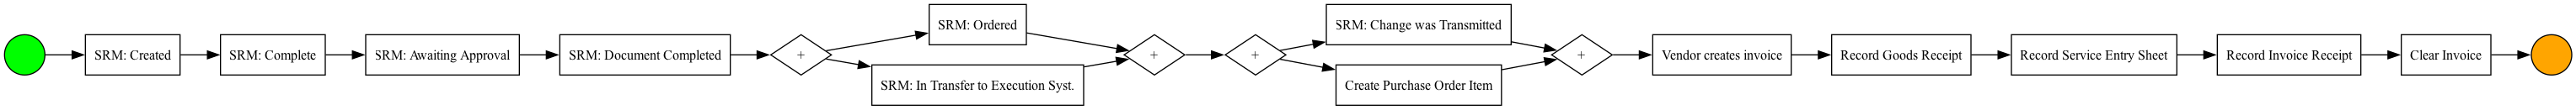

In [20]:
g = pm.discover_bpmn_inductive(filtered_dfs[0], .4)
pm.view_bpmn(g)

**Category 2**

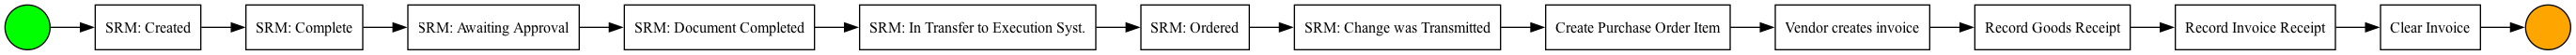

In [21]:
g = pm.discover_bpmn_inductive(filtered_dfs[1], .4)
pm.view_bpmn(g)

**Category 3**

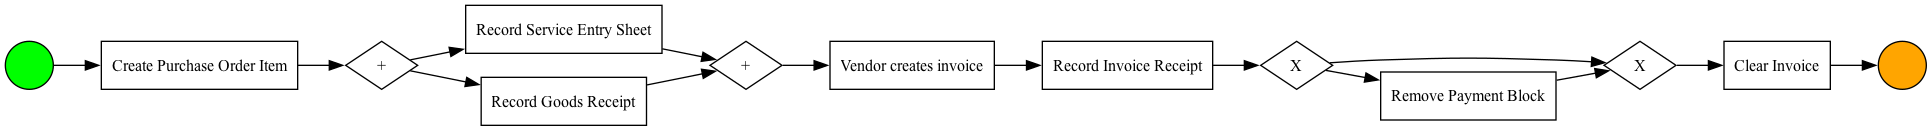

In [22]:
g = pm.discover_bpmn_inductive(filtered_dfs[2], .4)
pm.view_bpmn(g)

**Category 4**

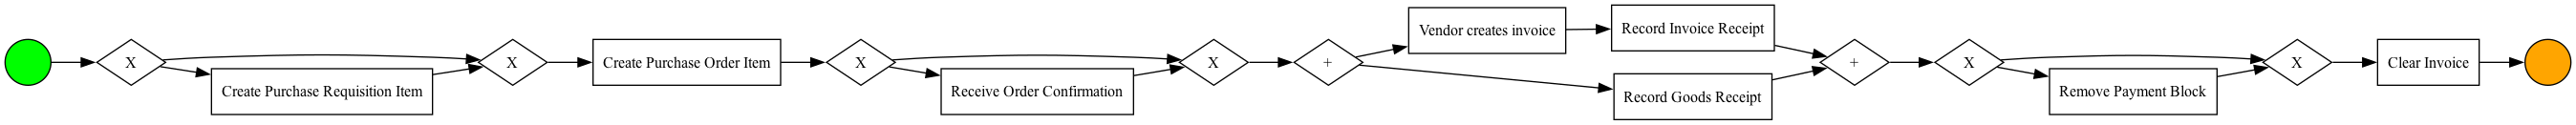

In [19]:
g = pm.discover_bpmn_inductive(filtered_dfs[3], .4)
pm.view_bpmn(g)

**Category 5**

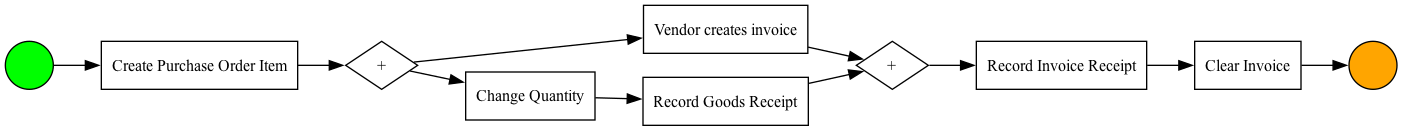

In [23]:
g = pm.discover_bpmn_inductive(filtered_dfs[4], .4)
pm.view_bpmn(g)

**Category 6**

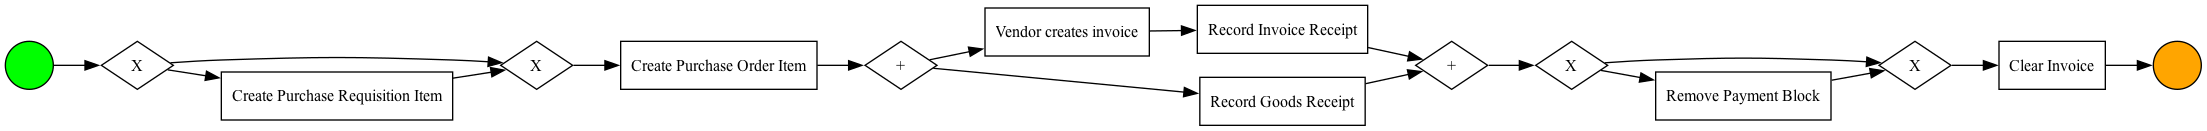

In [24]:
g = pm.discover_bpmn_inductive(filtered_dfs[5], .4)
pm.view_bpmn(g)

**Category 7**

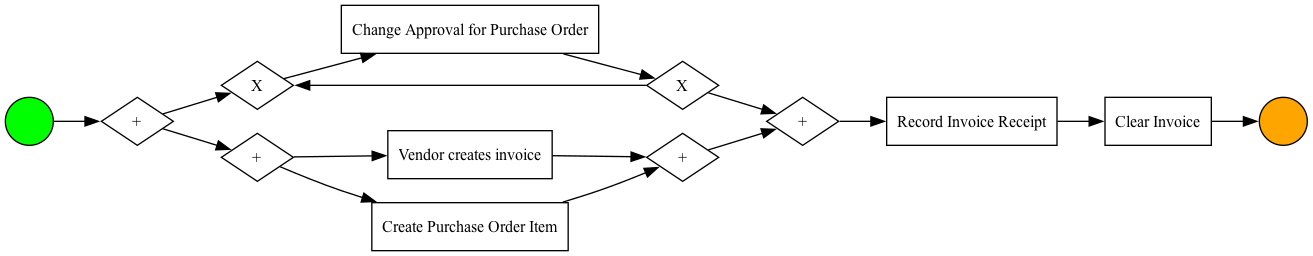

In [25]:
g = pm.discover_bpmn_inductive(filtered_dfs[6], .4)
pm.view_bpmn(g)

**Category 8**

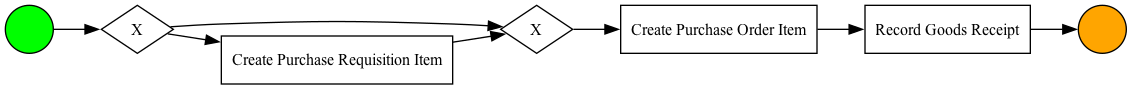

In [26]:
g = pm.discover_bpmn_inductive(filtered_dfs[7], .4)
pm.view_bpmn(g)

### Fitness

For each categorie compute the fitness of the models discovered in the previous section. 

In [65]:
diagnostics_array = []

for i in range(len(dataframes)):

    tmp_dict = {"category": i+1}
    
    net, im, fm = pm.discover_petri_net_inductive(filtered_dfs[i], noise_threshold=0.4, multi_processing=False)

    tbr_diagnostics = pm.conformance_diagnostics_token_based_replay(dataframes[i], net, im, fm, return_diagnostics_dataframe=True)

    tmp_dict["total_cases"] = len(tbr_diagnostics)
    tmp_dict["100%_fitting"] = len(tbr_diagnostics[tbr_diagnostics['trace_fitness'] == 1])
    tmp_dict["100%_ratio"] = tmp_dict["100%_fitting"] / tmp_dict["total_cases"]
    tmp_dict["80%_fitting"] = len(tbr_diagnostics[tbr_diagnostics['trace_fitness'] > .8])
    tmp_dict["80%_ratio"] = tmp_dict["80%_fitting"] / tmp_dict["total_cases"]
    diagnostics_array.append(tmp_dict)

diagnostics_df = pd.DataFrame(diagnostics_array)
diagnostics_df.style.format({
    '100%_ratio': '{:,.1%}'.format,
    '80%_ratio': '{:,.1%}'.format,
})

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/67 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/1955 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/185 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/35 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:508: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

,category,total_cases,100%_fitting,100%_ratio,80%_fitting,80%_ratio
0,1,213,93,43.7%,199,93.4%
1,2,787,284,36.1%,748,95.0%
2,3,831,695,83.6%,723,87.0%
3,4,162306,157334,96.9%,162302,100.0%
4,5,1487,980,65.9%,1417,95.3%
5,6,4211,3667,87.1%,4209,100.0%
6,7,166,148,89.2%,164,98.8%
7,8,13130,11850,90.3%,11850,90.3%


## Throughput Analysis

In [74]:
filtered_df.head()

,User,org:resource,concept:name,Cumulative net worth (EUR),time:timestamp,case:Spend area text,case:Company,case:Document Type,case:Sub spend area text,case:Purchasing Document,...,case:Vendor,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:concept:name,case:Goods Receipt
145,batch_00,batch_00,SRM: Created,18186.0,2018-01-08 14:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
146,batch_00,batch_00,SRM: Complete,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
147,batch_00,batch_00,SRM: Awaiting Approval,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
148,batch_00,batch_00,SRM: Document Completed,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
149,batch_00,batch_00,SRM: In Transfer to Execution Syst.,18186.0,2018-01-08 15:36:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True


### Filtering and Formatting Dataset

Retain only 3 activities:
- *Record Goods Receipt*
- *Record Invoice Receipt*
- *Clear Invoice*

In [196]:
invoice_df = filtered_df[(filtered_df["concept:name"].isin(['Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice',])) & (filtered_df["case:Item Category"] != "Consignment")]
invoice_df

,User,org:resource,concept:name,Cumulative net worth (EUR),time:timestamp,case:Spend area text,case:Company,case:Document Type,case:Sub spend area text,case:Purchasing Document,...,case:Vendor,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:concept:name,case:Goods Receipt
154,user_000,user_000,Record Goods Receipt,18186.0,2018-01-15 11:53:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
156,batch_00,batch_00,Record Invoice Receipt,18186.0,2018-01-17 14:49:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
157,user_002,user_002,Clear Invoice,18186.0,2018-02-22 15:18:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,ICT Software,2000000008,...,vendorID_0007,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0007,True,00001,2000000008_00001,True
168,user_000,user_000,Record Goods Receipt,1039.0,2018-03-08 07:27:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Laboratory Supplies & Services,2000000009,...,vendorID_0008,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0008,True,00001,2000000009_00001,True
169,user_001,user_001,Record Invoice Receipt,1039.0,2018-03-09 15:47:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Laboratory Supplies & Services,2000000009,...,vendorID_0008,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0008,True,00001,2000000009_00001,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595821,user_604,user_604,Clear Invoice,5744.0,2019-01-16 16:23:00+00:00,,companyID_0003,Framework order,,4508076340,...,vendorID_1971,Limit,2-way match,,sourceSystemID_0000,vendor_1895,False,00010,4508076340_00010,False
1595829,user_359,user_359,Record Invoice Receipt,1300.0,2019-01-11 15:58:00+00:00,Real Estate,companyID_0003,Framework order,Real estate brokers or agents,4508076342,...,vendorID_1864,Limit,2-way match,NPR,sourceSystemID_0000,vendor_1788,False,00010,4508076342_00010,False
1595830,user_604,user_604,Clear Invoice,1300.0,2019-01-16 16:23:00+00:00,Real Estate,companyID_0003,Framework order,Real estate brokers or agents,4508076342,...,vendorID_1864,Limit,2-way match,NPR,sourceSystemID_0000,vendor_1788,False,00010,4508076342_00010,False
1595838,user_359,user_359,Record Invoice Receipt,574.0,2019-01-14 10:08:00+00:00,Workforce Services,companyID_0003,Framework order,Travel & expenses,4508076344,...,vendorID_1972,Limit,2-way match,NPR,sourceSystemID_0000,vendor_1896,False,00010,4508076344_00010,False


Adding a new column for *Invoice Iteration* to the dataset 

In [198]:
list_subdf = []

for case, subdf in invoice_df.groupby(by=["case:concept:name"]):
    
    invoice_tmp_array = [0] * len(subdf)
    gr_count = 1
    ir_count = 1
    ci_count = 1
    
    for idx, e in enumerate(subdf["concept:name"]):
        if(e == "Record Goods Receipt"):
            invoice_tmp_array[idx] = gr_count
            gr_count += 1
        elif(e == "Record Invoice Receipt"):
            invoice_tmp_array[idx] = ir_count
            ir_count += 1
        else:
            invoice_tmp_array[idx] = ci_count
            ci_count += 1

    invoice_tmp_array

    subdf.insert(len(subdf.columns), "invoice_iter", invoice_tmp_array)
    list_subdf.append(subdf)


invoice_df = pd.concat(list_subdf)
invoice_df.head()

,User,org:resource,concept:name,Cumulative net worth (EUR),time:timestamp,case:Spend area text,case:Company,case:Document Type,case:Sub spend area text,case:Purchasing Document,...,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:concept:name,case:Goods Receipt,invoice_iter
9,user_000,user_000,Record Goods Receipt,298.0,2018-03-06 06:44:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True,1
10,user_001,user_001,Record Invoice Receipt,298.0,2018-03-06 07:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True,1
11,user_002,user_002,Clear Invoice,298.0,2018-03-29 13:06:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,00001,2000000000_00001,True,1
54,user_000,user_000,Record Goods Receipt,28.0,2018-01-12 13:14:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,Office Supplies,2000000003,...,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0003,False,00001,2000000003_00001,True,1
55,user_001,user_001,Record Invoice Receipt,28.0,2018-02-12 15:58:00+00:00,Enterprise Services,companyID_0000,EC Purchase order,Office Supplies,2000000003,...,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0003,False,00001,2000000003_00001,True,1


### Partitioning Dataset

In [241]:
invoice_GR_before_IR_df = invoice_df[invoice_df["case:Item Category"] == "3-way match, invoice before GR"]
invoice_2_way_df = invoice_df[invoice_df["case:Item Category"] == "2-way match"]
invoice_GR_after_IR_df = invoice_df[invoice_df["case:Item Category"] == "3-way match, invoice after GR"]

Computing Invoice Throughput

In [242]:
def compute_invoicing_times(data, two_way=False):

    results = []
    
    for case, subdata in data.groupby(by=["case:concept:name"]):

        res_dict = {"case": case[0], "item_category": subdata["case:Item Category"].iloc[0], "item_type": subdata["case:Item Type"].iloc[0], "document_type": subdata["case:Document Type"].iloc[0]}
        invoice_receipt_times = []
        clearing_times = []
        
        for i in range(max(subdata["invoice_iter"].unique())):

            tmp = subdata[subdata["invoice_iter"] == (i + 1)]

            invoice_receipt = tmp[tmp["concept:name"] == "Record Invoice Receipt"]["time:timestamp"].values
            if not two_way:
                goods_receipt = tmp[tmp["concept:name"] == "Record Goods Receipt"]["time:timestamp"].values
            clear_invoice = tmp[tmp["concept:name"] == "Clear Invoice"]["time:timestamp"].values

            if two_way: #2-WAY MATCH
                clearing_times.append(clear_invoice - invoice_receipt)
            else:
                if(invoice_receipt > goods_receipt):
                    invoice_receipt_times.append(invoice_receipt - goods_receipt)
                    clearing_times.append(clear_invoice - invoice_receipt)
                else:
                    invoice_receipt_times.append(goods_receipt - invoice_receipt)
                    clearing_times.append(clear_invoice - goods_receipt)

        if not two_way:
            res_dict["invoice_receipt_time"] = np.mean(invoice_receipt_times)
        res_dict["clearing_time"] = np.mean(clearing_times)

        results.append(res_dict)

    return results

In [243]:
type_1_results = pd.DataFrame(compute_invoicing_times(invoice_GR_after_IR_df))
type_2_results = pd.DataFrame(compute_invoicing_times(invoice_GR_before_IR_df))
type_3_results = pd.DataFrame(compute_invoicing_times(invoice_2_way_df, two_way=True))

### Visualize Results

In [245]:
type_1_results.iloc[:,1:]

,item_category,item_type,document_type,invoice_receipt_time,clearing_time
0,"3-way match, invoice after GR",Service,EC Purchase order,2 days 02:56:00,36 days 00:29:00
1,"3-way match, invoice after GR",Service,EC Purchase order,1 days 08:20:00,5 days 21:26:00
2,"3-way match, invoice after GR",Service,EC Purchase order,8 days 02:48:00,21 days 21:36:00
3,"3-way match, invoice after GR",Service,EC Purchase order,1 days 03:41:00,9 days 14:36:00
4,"3-way match, invoice after GR",Service,EC Purchase order,5 days 19:00:00,2 days 06:52:00
...,...,...,...,...,...
7511,"3-way match, invoice after GR",Third-party,Standard PO,4 days 01:51:00,24 days 05:31:00
7512,"3-way match, invoice after GR",Third-party,Standard PO,4 days 01:51:00,24 days 05:31:00
7513,"3-way match, invoice after GR",Third-party,Standard PO,4 days 01:51:00,24 days 05:31:00
7514,"3-way match, invoice after GR",Third-party,Standard PO,1 days 00:38:00,7 days 04:19:00


In [348]:
def group_data(df_to_group, two_way=False):
    df_to_return = df_to_group.iloc[:,1:].groupby(['item_category', 'item_type', 'document_type']).mean()
    if not two_way:
        df_to_return["invoice_receipt_time"] = df_to_return["invoice_receipt_time"].dt.round('1h')
    df_to_return["clearing_time"] = df_to_return["clearing_time"].dt.round('1h')

    return df_to_return

def timedelta_to_float(to_transform):
    to_return = []

    for delta in to_transform:
        to_return.append(delta.days + (delta.seconds/3600/24))

    return to_return

def format_for_plotting(df_to_format, two_way=False):

    df_to_return = pd.DataFrame()

    if not two_way:
        df_to_return["invoice_receipt_time"] = timedelta_to_float(df_to_format["invoice_receipt_time"])
    df_to_return["clearing_time"] = timedelta_to_float(df_to_format["clearing_time"])

    tmp = []
    for i, row in df_to_format.iterrows():
        tmp.append(i[1] + " - " + i[2])

    df_to_return.insert(0, "type", tmp)
    df_to_return.set_index("type", inplace=True)

    return df_to_return   

In [347]:
type_1_grouped = group_data(type_1_results)
type_2_grouped = group_data(type_2_results)
type_3_grouped = group_data(type_3_results, two_way=True)

In [351]:
type_1_plot = format_for_plotting(type_1_grouped)
type_2_plot = format_for_plotting(type_2_grouped)
type_3_plot = format_for_plotting(type_3_grouped, two_way=True)

In [353]:
type_2_plot

,invoice_receipt_time,clearing_time
type,,
Standard - EC Purchase order,28.833333,22.208333
Standard - Standard PO,17.041667,49.416667
Subcontracting - Standard PO,24.250000,46.541667
Third-party - Standard PO,15.833333,35.500000


In [360]:
def plot_thoughput_times(data, title, two_way=False):

    colors = ['lightskyblue', 'lightgreen']
    ax = data.plot(kind='bar', figsize=(len(data) * 2.5, 6), rot=0, width=0.85, color=colors)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.bar_label(ax.containers[0], label_type='edge', fmt='%.2f')
    if not two_way:
        ax.bar_label(ax.containers[1], label_type='edge', fmt='%.2f')
    ax.tick_params(axis='x', labelrotation=60)
    
    plt.title(title)     
    # giving X and Y labels
    plt.xlabel("Categories")
    plt.ylabel("Days")
    
    plt.show()

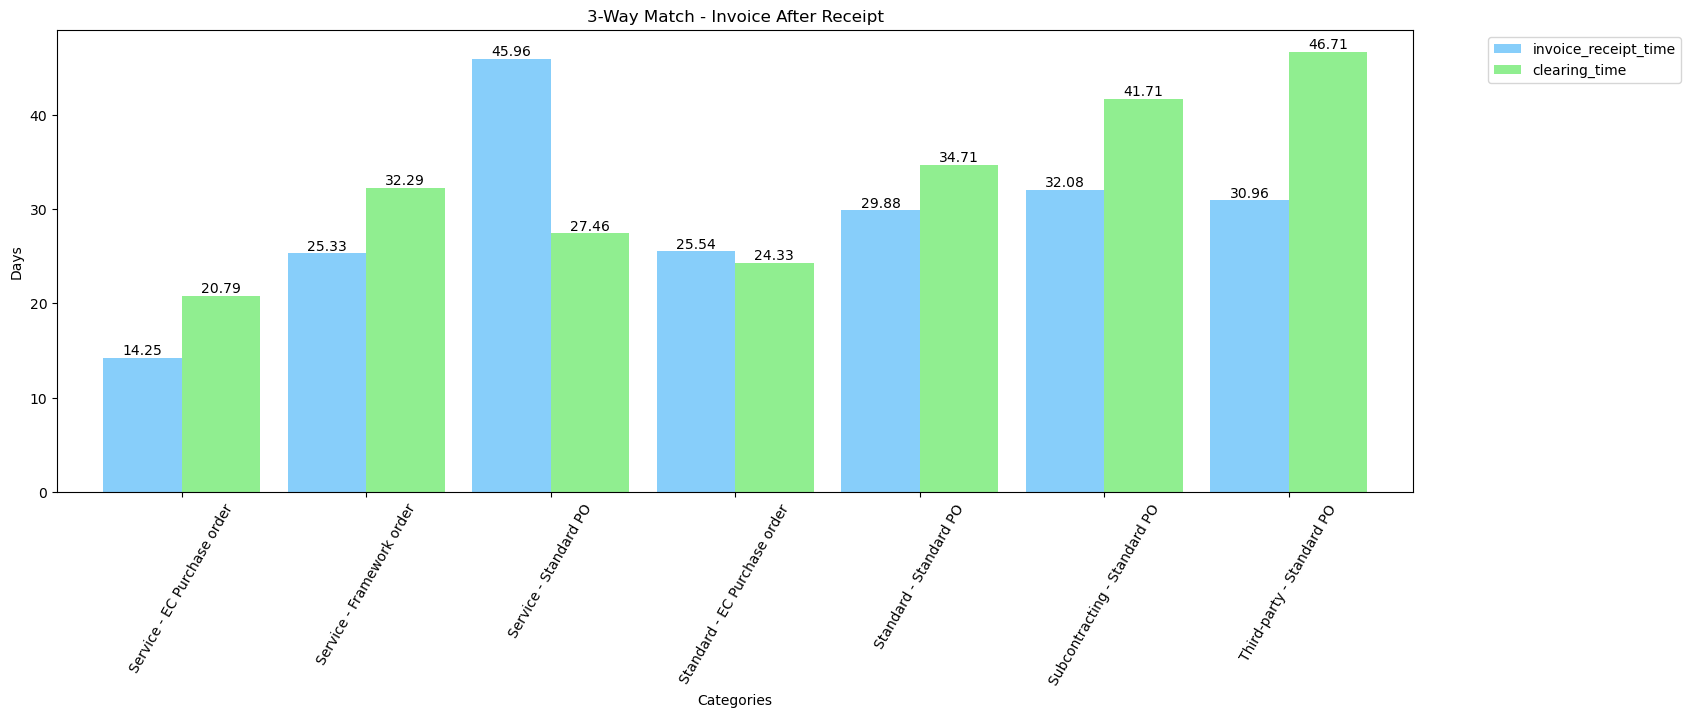

In [364]:
plot_thoughput_times(type_1_plot, "3-Way Match - Invoice After Receipt")

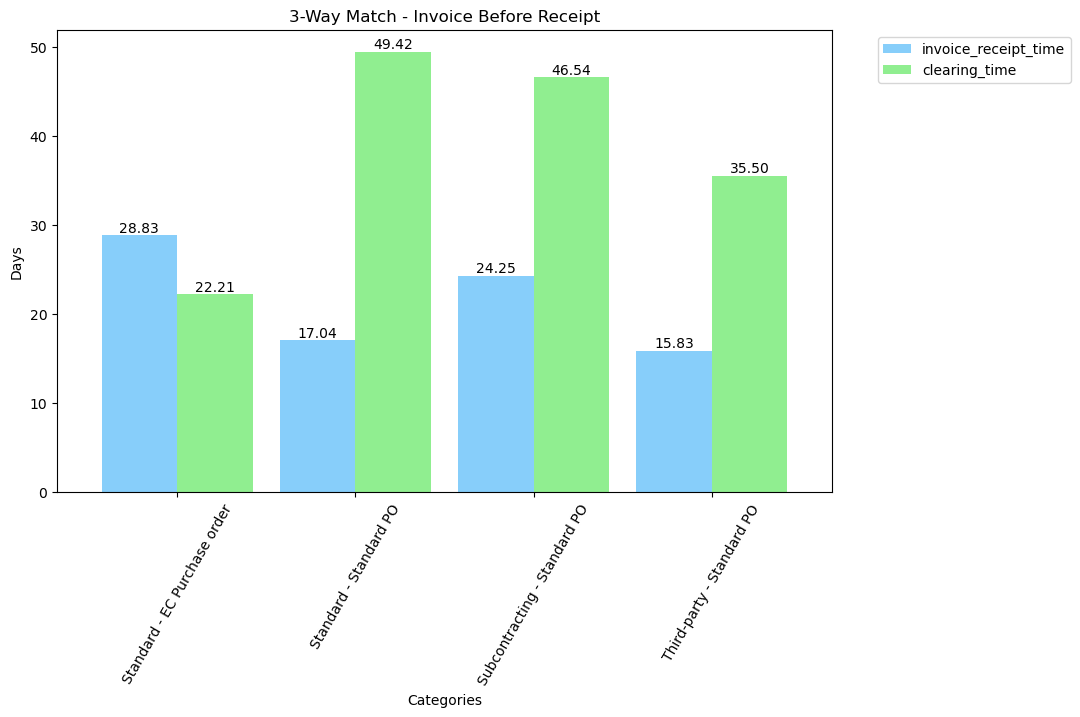

In [363]:
plot_thoughput_times(type_2_plot, "3-Way Match - Invoice Before Receipt")

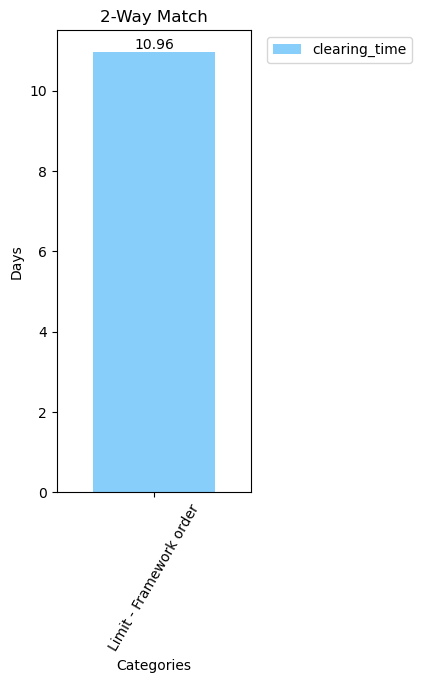

In [361]:
plot_thoughput_times(type_3_plot, "2-Way Match", True)

## Anomalies Analysis

### Remove Payment Block

In [250]:
#pm.filter_event_attribute_values(filtered_df, 'concept:name', ["Set Payment Block", "Remove Payment Block"])
len(pm.filter_event_attribute_values(filtered_df, 'concept:name', ["Remove Payment Block"])["case:concept:name"].unique()), len(pm.filter_event_attribute_values(filtered_df, 'concept:name', ["Set Payment Block"])["case:concept:name"].unique())

(44468, 42)

In [248]:
len(pm.filter_eventually_follows_relation(filtered_df, [("Set Payment Block", "Remove Payment Block")])["case:concept:name"].unique())

10

### Purchase Document

In [296]:
n_events = []

for doc, subdata in filtered_df.groupby(by=["case:Purchasing Document", "case:Item Category", "case:Document Type", "case:Item Type"]):
    n_events.append((doc[0], doc[1], doc[2], doc[3], len(subdata)))

n_events_df = pd.DataFrame(n_events, columns=['Purchase Document', 'Item Category', 'Document Type', 'Item Type', 'n_events']).sort_values('n_events', ascending=False)
n_events_df[:20]

,Purchase Document,Item Category,Document Type,Item Type,n_events
14114,4507016120,"3-way match, invoice before GR",Standard PO,Standard,1448
46858,4508054253,"3-way match, invoice before GR",Standard PO,Standard,1448
14600,4507016719,"3-way match, invoice before GR",Standard PO,Standard,1354
5211,4507005576,"3-way match, invoice before GR",Standard PO,Standard,1264
41405,4508047531,"3-way match, invoice before GR",Standard PO,Third-party,954
29721,4507034373,"3-way match, invoice before GR",Standard PO,Standard,946
14931,4507017109,"3-way match, invoice before GR",Standard PO,Subcontracting,914
11947,4507013377,"3-way match, invoice before GR",Standard PO,Standard,834
17329,4507019927,"3-way match, invoice before GR",Standard PO,Standard,697
10600,4507011824,"3-way match, invoice before GR",Standard PO,Standard,681


In [266]:
doc_to_analyze = n_events_df[:40]['Purchase Document'].to_list()

huge_cases_df = filtered_df[[x in doc_to_analyze for x in filtered_df['case:Purchasing Document']]]

In [219]:
#Compute mean and median of number of events

np.mean(n_events_df["n_events"]), np.median(n_events_df["n_events"])

(18.485034647943976, 6.0)

In [205]:
occ_df = n_events_df.groupby('n_events').size().to_frame().sort_values(0, ascending=False).reset_index().rename(columns={0: 'count'})
occ_df

,n_events,count
0,6,12167
1,5,10710
2,7,4243
3,10,2949
4,2,2660
...,...,...
369,316,1
370,315,1
371,311,1
372,247,1


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'n_activities x case')

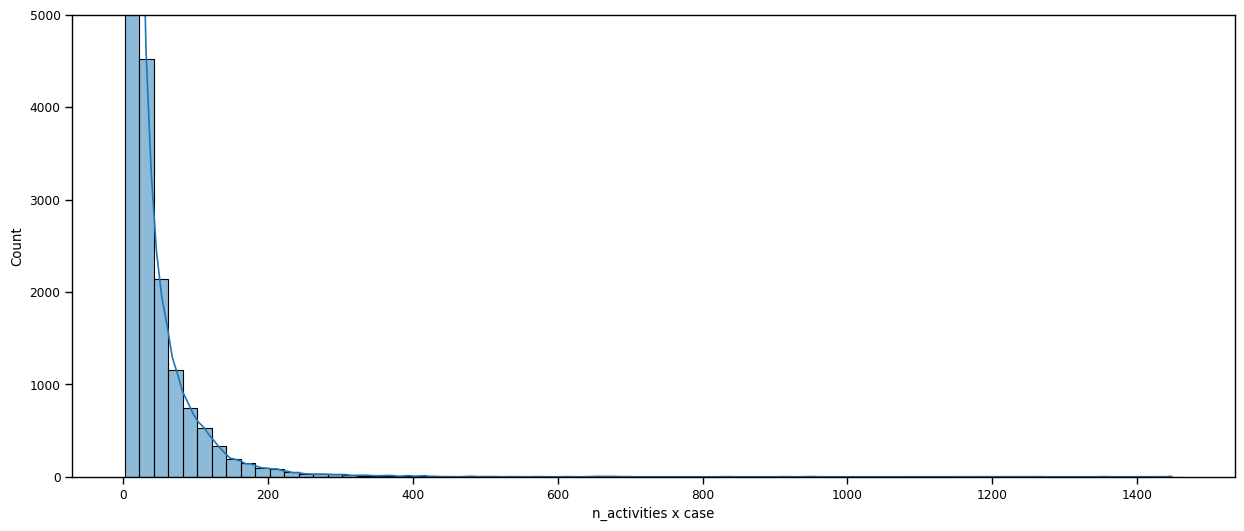

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
sns.histplot(data=n_events_df, x='n_events', binwidth=20, kde=True)
plt.ylim(0, 5000)
plt.xlabel('n_activities x case')

### Rework Activities

In [283]:
activities = filtered_df["concept:name"].unique()
rework_keys = ["Change", "Delete", "Cancel"]
rework_activities = [y for y in activities if any(x in y for x in rework_keys)] 

In [284]:
rework_activities

['SRM: Change was Transmitted',
 'SRM: Deleted',
 'Change Price',
 'Cancel Invoice Receipt',
 'Change Quantity',
 'Change Delivery Indicator',
 'Change Approval for Purchase Order',
 'Cancel Subsequent Invoice',
 'Change Final Invoice Indicator',
 'Delete Purchase Order Item',
 'Change Rejection Indicator',
 'Change Storage Location',
 'Cancel Goods Receipt',
 'Change Currency',
 'Change payment term']

In [297]:
rework_serie = [1 if x in rework_activities else 0 for x in filtered_df["concept:name"] ]
rework_df = filtered_df[["User", "concept:name", "case:concept:name", "case:Purchasing Document"]]
rework_df["rework_activities"] = rework_serie
rework_df

/var/folders/w0/g_3__5dd6d94dchsj21skdjw0000gn/T/ipykernel_4399/1497041668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rework_df["rework_activities"] = rework_serie


,User,concept:name,case:concept:name,case:Purchasing Document,rework_activities
145,batch_00,SRM: Created,2000000008_00001,2000000008,0
146,batch_00,SRM: Complete,2000000008_00001,2000000008,0
147,batch_00,SRM: Awaiting Approval,2000000008_00001,2000000008,0
148,batch_00,SRM: Document Completed,2000000008_00001,2000000008,0
149,batch_00,SRM: In Transfer to Execution Syst.,2000000008_00001,2000000008,0
...,...,...,...,...,...
1586987,user_094,Record Goods Receipt,4508075857_00040,4508075857,0
1586988,user_121,Create Purchase Order Item,4508075857_00050,4508075857,0
1586989,user_094,Record Goods Receipt,4508075857_00050,4508075857,0
1586990,user_121,Create Purchase Order Item,4508075857_00060,4508075857,0


In [330]:
rework_act = rework_df[rework_df['rework_activities'] == 1].groupby(by=['concept:name']).size().to_frame().sort_values(0, ascending=False).rename(columns={0: 'occurrences'})
rework_act.index.names = ['activity']
rework_act

,occurrences
activity,
Change Quantity,13344
Change Price,8614
Change Approval for Purchase Order,2617
Change Delivery Indicator,1294
SRM: Change was Transmitted,1000
Change Storage Location,258
Cancel Invoice Receipt,245
Delete Purchase Order Item,225
Cancel Goods Receipt,183


In [317]:
rework_agg_df = rework_df.groupby(by=['User']).agg({'case:concept:name': lambda x: x.nunique(), 'concept:name': 'count', 'rework_activities': 'sum'}).sort_values("rework_activities", ascending=False)
rework_agg_df["rework_percentage"] = rework_agg_df["rework_activities"] / rework_agg_df["concept:name"]
user_rework = rework_agg_df.rename(columns={"User": "users", "case:concept:name": "cases", "concept:name": "activities"}).sort_values(["rework_percentage", 'activities'], ascending=False)
user_rework[(user_rework["rework_percentage"] > 0.5) & (user_rework["activities"] > 50)]

,cases,activities,rework_activities,rework_percentage
User,,,,
user_037,1160,1190,1190,1.000000
user_039,1012,1037,1037,1.000000
user_081,270,276,276,1.000000
user_317,156,260,260,1.000000
user_603,166,256,256,1.000000
user_069,240,246,246,1.000000
user_115,194,214,214,1.000000
user_307,161,161,161,1.000000
user_358,51,53,53,1.000000
